### Loading images and labels


In [1]:
from scipy.misc import imread, imresize
#from keras.applications.imagenet_utils import preprocess_input
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Predicting on a batch of images

The predict_batch function is defined as follows:

    - open each image, and resize them to img_size
    - stack them as a batch tensor of shape (batch, img_size_x, img_size_y)
    - preprocess the batch and make a forward pass with the model



In [2]:
#def predict_batch(model, img_batch_path, img_size=None):
def predict_batch(folder, img_size=None):
    img_list = []
    label_list = []

    for filename in os.listdir(folder):
        
        if filename.endswith(".jpg"):
            img = imread(os.path.join(folder,filename))
            lb = filename.split('_')[1]
            lb = lb.lower()
        
        if img_size:
            img = imresize(img,img_size)

        img = img.astype('float32')
        
        # convert image to greyscale
        img = img.sum(axis=2) / 3.
        img /= np.std(img)
        
        img = img[:, :, np.newaxis]
        
        img_list.append(img)
        label_list.append(lb)
    try:
        img_batch = np.stack(img_list, axis=0)
    except:
        raise ValueError(
            'when both img_size and crop_size are None, all images '
            'in image_paths must have the same shapes.')

    #batch = preprocess_input(img_batch)
    return img_batch, label_list 
            #model.predict(img_batch)

In [3]:
YOUR_FOLDER_NAME = "try"

output, labels = predict_batch(YOUR_FOLDER_NAME, (32, 100))
print("output shape", output.shape)
print ('label shape', len(labels))

output shape (4, 32, 100, 1)
label shape 4


In [4]:
labels

['brewpubs', 'chuffed', 'captions', 'chickenshit']

In [5]:
output[0][:,:,0].shape

(32, 100)

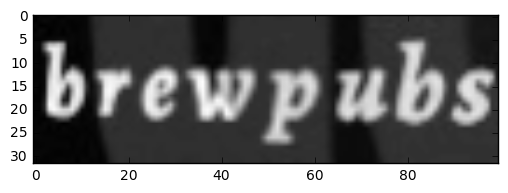

In [6]:
plt.imshow(output[0][:,:,0], cmap="gray")

### Conv-net model

The base CNN has five convolutional layers and two fully connected layers. 

In [7]:

from keras import models
from keras.layers import Flatten, Dropout, MaxPooling2D
from keras.layers import Dense, InputLayer, Convolution2D
import logging
import numpy as np

import keras.backend as K
import tensorflow as tf

def squeeze_dim(x, axis=-1):
    # Removes a 1-dimension from the tensor at index "axis"
    return K.squeeze(x, axis=axis)


class CNN(object):
    """
    Usage for tf tensor output:
    o = CNN(x).tf_output()
    """

    def __init__(self, input_tensor):
        self._build_network(input_tensor)

    def _build_network(self, input_tensor):

        model = models.Sequential()
        
        # input layer
        input_layer = InputLayer(input_shape=(None,32,100))  #batch_size, H, W
        # if input_tensor is not None:
        input_layer.set_input(input_tensor=input_tensor)
        model.add(input_layer)

        # first convolutional layer
        model.add(Convolution2D(64, 5, 5, activation='relu', subsample=(1, 1),border_mode='same'))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
        model.add(Dropout(0.2))
        #print ('conv1', model.output_shape)

        # second convolutional layer
        model.add(Convolution2D(128, 5, 5, activation='relu',subsample=(1, 1),border_mode='same'))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
        model.add(Dropout(0.2))
        #print ('conv2', model.output_shape)

        # third convolutional layer
        model.add(Convolution2D(256, 3, 3, activation='relu',subsample=(1, 1),border_mode='same'))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
        model.add(Dropout(0.2))
        #print ('conv3', model.output_shape)

        # fourth convolutional layer
        model.add(Convolution2D(512, 3, 3, activation='relu',subsample=(1, 1),border_mode='same'))
        model.add(Dropout(0.2))
        #print ('conv4', model.output_shape)

        # fifth convolutional layer
        model.add(Convolution2D(512, 3, 3, activation='relu', subsample=(1, 1),border_mode='same')) 
        model.add(Dropout(0.2))
        #print ('conv5', model.output_shape)
    
        # first fully connected layer
        model.add(Flatten())
        model.add(Dense(4096, activation='relu')) 
        model.add(Dropout(0.2))
        #print ('fully1', model.output_shape)
        
        # second fully connected layer
        model.add(Dense(4096))
        #print ('fully2', model.output_shape)

        self.model = model

    def tf_output(self):
        # if self.input_tensor is not None:
        return self.model.output

    def __call__(self, input_tensor):
        return self.model(input_tensor)
    
    def tf_summary(self):
        print(self.model.summary())

    def save(self, filename):
        self.model.save_weights(str(filename) + ".h5")
        print("Model saved to disk")




Using TensorFlow backend.


In [8]:
model_cnn = CNN(tf.Variable(output))

In [9]:
model_cnn.tf_summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (4, 32, 100, 1)       0                                            
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (4, 32, 100, 64)      1664        input_1[0][0]                    
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (4, 16, 50, 64)       0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
dropout_1 (Dropout)              (4, 16, 50, 64)       0           maxpooling2d_1[0][0]             
___________________________________________________________________________________________

In [10]:
model_cnn.save('model_null')

Model saved to disk


In [ ]:
# train model

from keras.utils.np_utils import accuracy

model.compile(loss = binary_crossentropy, optimizer='adam')
model.fit({'input': X_train, 'output': y_train},
          batch_size=batch_size,
          nb_epoch=nb_epoch,
          validation_data={'input': X_test, 'output': y_test})
acc = accuracy(y_test,
               np.round(np.array(model.predict({'input': X_test},
                                               batch_size=batch_size)['output'])))
print('Test accuracy:', acc)